<a href="https://colab.research.google.com/github/blackst3r/computervision/blob/main/fruitclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [260]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [261]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [262]:
base_dir = '/content/drive/MyDrive/MY_data/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')
test_dir = os.path.join(base_dir, 'predict')

In [263]:
BATCH_SIZE = 128
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2301 files belonging to 10 classes.


In [264]:
class_names = train_dataset.class_names
print(class_names)

['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


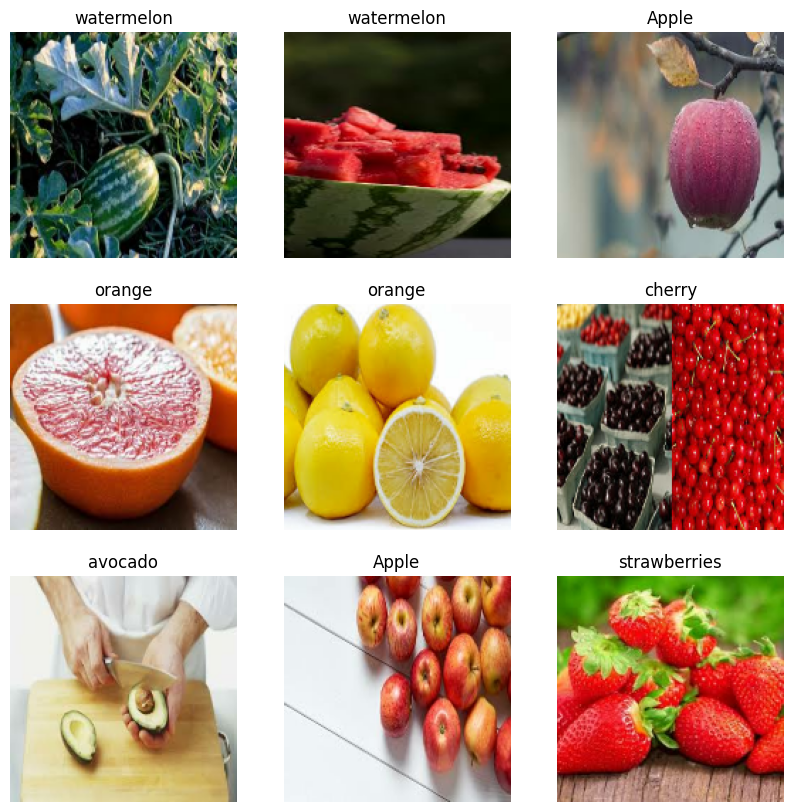

In [265]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [266]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1025 files belonging to 10 classes.


In [ ]:
test_dir

'/content/drive/MyDrive/MY_data/predict'

In [ ]:
import glob

In [ ]:
data_path = os.path.join(test_dir, '*g')

In [ ]:
files = glob.glob(data_path)

In [ ]:
test_dir

'/content/drive/MyDrive/MY_data/predict'

In [267]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels = None,  
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)


Found 48 files belonging to 1 classes.


In [268]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [269]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)])


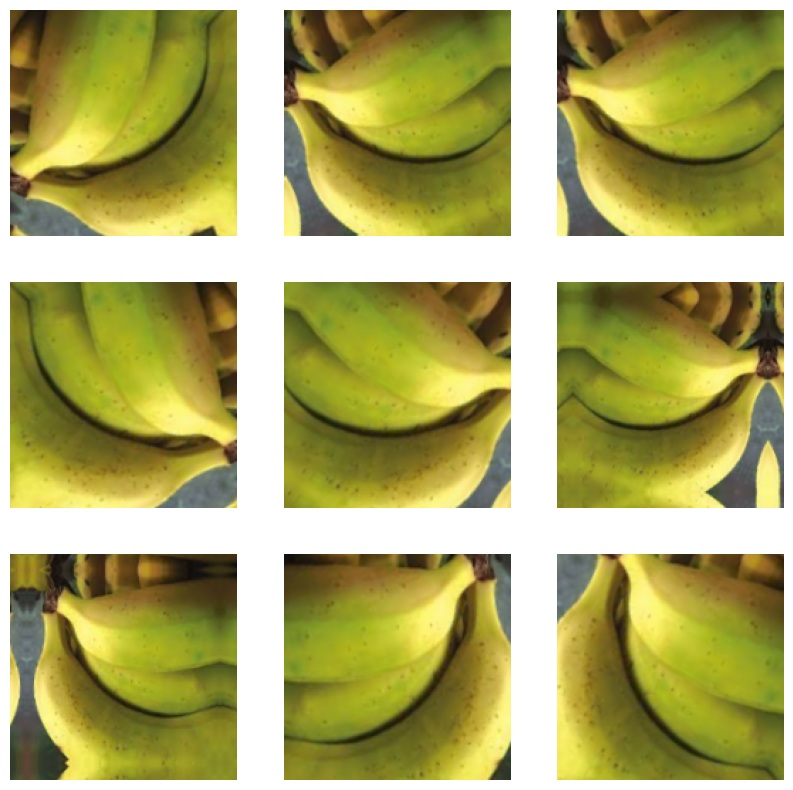

In [270]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [271]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [272]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [273]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 960)


In [274]:
base_model.trainable = False

In [275]:
from tensorflow.keras.models import Sequential
mobile_model = Sequential()

for layer in base_model.layers:
        layer.trainable=False

mobile_model.add(base_model)

In [276]:
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

(128, 960)


In [277]:
#prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

(128, 10)


In [278]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D

In [279]:
mobile_model.add(Flatten())
mobile_model.add(Dense(512, activation='relu'))
mobile_model.add(Dense(128, activation='relu'))
mobile_model.add(Dropout(0.2))
mobile_model.add(Dense(10, activation='softmax'))

In [280]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
#mobile_model = tf.keras.Model(inputs, outputs)

In [281]:
base_learning_rate = 0.0001
mobile_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [282]:
mobile_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 24000)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               12288512  
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 10)                1290      
                                                     

In [283]:
initial_epochs = 20

loss0, accuracy0 = mobile_model.evaluate(validation_dataset)

9/9 [==============================] - 3s 72ms/step - loss: 4.1147 - accuracy: 0.0761


In [284]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.11
initial accuracy: 0.08


In [285]:
history = mobile_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
18/18 [==============================] - 9s 185ms/step - loss: 1.5845 - accuracy: 0.5424 - val_loss: 1.8298 - val_accuracy: 0.6341
Epoch 2/20
18/18 [==============================] - 4s 171ms/step - loss: 0.1522 - accuracy: 0.9548 - val_loss: 2.1359 - val_accuracy: 0.6595
Epoch 3/20
18/18 [==============================] - 4s 183ms/step - loss: 0.0434 - accuracy: 0.9913 - val_loss: 2.2535 - val_accuracy: 0.6702
Epoch 4/20
18/18 [==============================] - 4s 179ms/step - loss: 0.0204 - accuracy: 0.9974 - val_loss: 2.3166 - val_accuracy: 0.6722
Epoch 5/20
18/18 [==============================] - 4s 168ms/step - loss: 0.0148 - accuracy: 0.9983 - val_loss: 2.3757 - val_accuracy: 0.6741
Epoch 6/20
18/18 [==============================] - 4s 174ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 2.4368 - val_accuracy: 0.6741
Epoch 7/20
18/18 [==============================] - 4s 191ms/step - loss: 0.0080 - accuracy: 0.9991 - val_loss: 2.4881 - val_accuracy: 0.6751
Epoch 

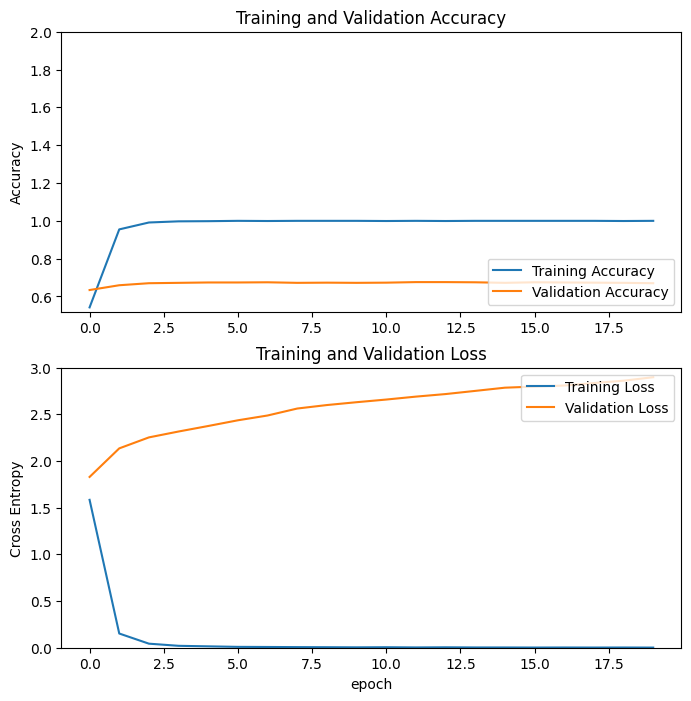

In [286]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [287]:
base_model.trainable = True

In [288]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 160

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [289]:
base_model.summary() 

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 160, 160, 3)  0           ['input_17[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 80, 80, 16)   432         ['rescaling_7[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 80, 80, 16)  64          ['Conv[0][0]']    

In [290]:
mobile_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [291]:
mobile_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 24000)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               12288512  
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 10)                1290      
                                                     

In [294]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5)
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = mobile_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[callback])


Epoch 20/40
18/18 [==============================] - 6s 233ms/step - loss: 0.0432 - accuracy: 0.9900 - val_loss: 3.0528 - val_accuracy: 0.6702
Epoch 21/40
18/18 [==============================] - 5s 252ms/step - loss: 0.0268 - accuracy: 0.9961 - val_loss: 3.0958 - val_accuracy: 0.6741
Epoch 22/40
18/18 [==============================] - 5s 234ms/step - loss: 0.0229 - accuracy: 0.9957 - val_loss: 3.1349 - val_accuracy: 0.6751
Epoch 23/40
18/18 [==============================] - 5s 234ms/step - loss: 0.0183 - accuracy: 0.9974 - val_loss: 3.1757 - val_accuracy: 0.6722
Epoch 24/40
18/18 [==============================] - 5s 239ms/step - loss: 0.0135 - accuracy: 0.9991 - val_loss: 3.2098 - val_accuracy: 0.6732
Epoch 25/40
18/18 [==============================] - 5s 233ms/step - loss: 0.0115 - accuracy: 0.9978 - val_loss: 3.2416 - val_accuracy: 0.6751


In [295]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

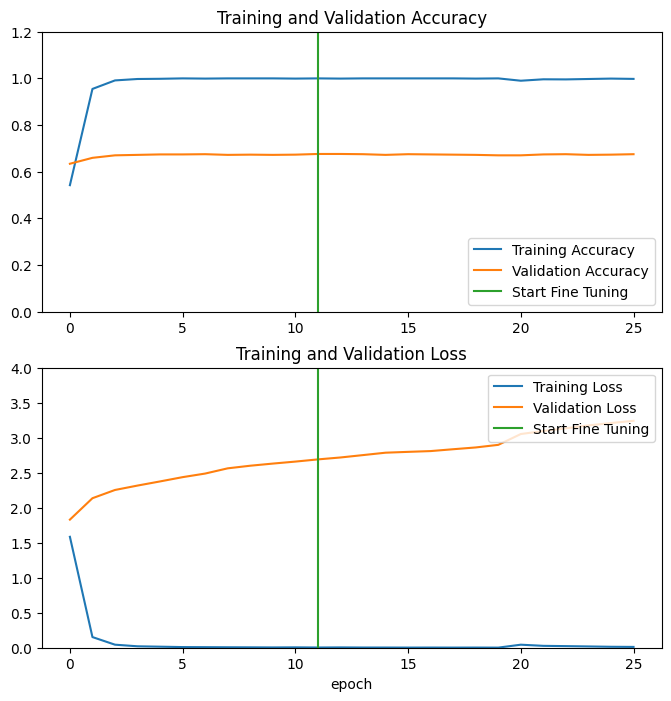

In [297]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])
plt.plot([11,11],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([11,11],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [0 1 8 4 4 6 4 1 5 2 2 4 2 7 5 2 8 3 0 8 9 0 0 8 7 1 9 1 8 5 4 7 3 9 7 9 3
 6 3 0 6 3 3 7 8 6 6 5]


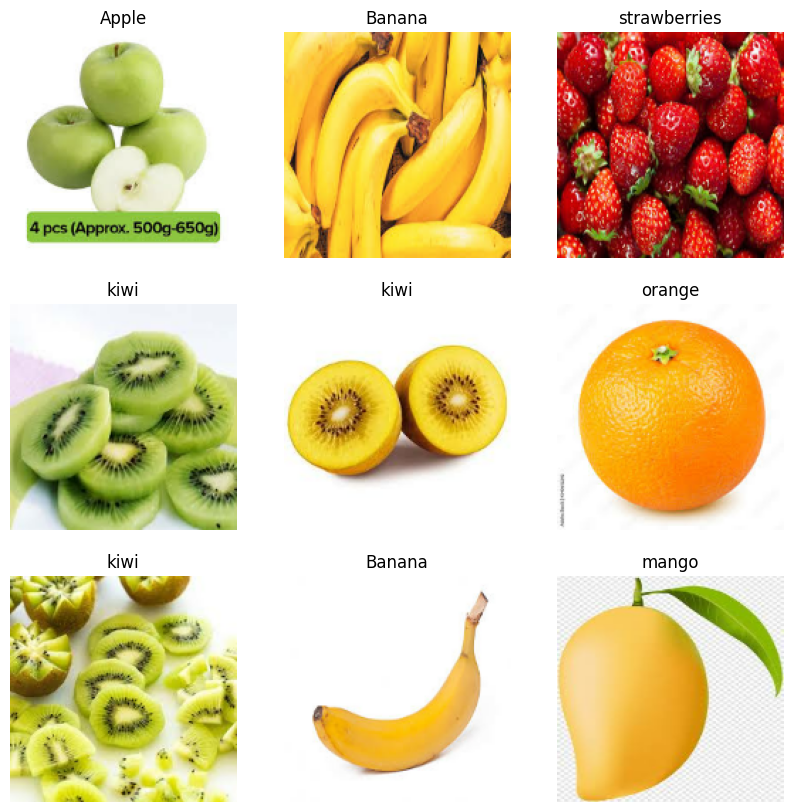

In [301]:
# Retrieve a batch of images from the test set
image_batch = test_dataset.as_numpy_iterator().next()
predictions = mobile_model.predict_on_batch(image_batch)

# Find the class with highest predicted probability
predictions = np.argmax(predictions, axis=-1)

class_names = ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


print('Predictions:\n', predictions)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
